In [11]:
import datetime
import time
import math
import itertools
import pandas as pd
import numpy as np
import scipy.stats as stat
from numpy import std, mean
#import statsmodels.api as sm
import statsmodels.stats as sm_stats
from statsmodels.stats.proportion import proportions_ztest
import ast
import re, string, unicodedata
import copy
import pyodbc
import matplotlib.pyplot as plt
import seaborn as sns
import causal_functions
from datetime import date, datetime
from dateutil.relativedelta import relativedelta

from sklearn.model_selection import train_test_split
from sklearn.base import RegressorMixin, BaseEstimator, ClassifierMixin
from sklearn.metrics import average_precision_score
from catboost import CatBoostClassifier, CatBoostRegressor, to_classifier, EFstrType
from econml.dml import CausalForestDML, DML, LinearDML
from econml.dr import DRLearner, ForestDRLearner
import shap
shap.initjs() 

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
from pyspark.sql import Window
from pyspark.sql import functions as f 
from pyspark.sql.functions import row_number
from pyspark.sql import types
from pyspark.sql.types import *
from pyspark import SparkConf
from pyspark.sql.functions import udf
from pyspark.sql.functions import col, countDistinct,concat, isnan, when, count
import os
import subprocess

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

### Assign Variables

In [4]:
#Cohort and related dates
MMYYYY = '072022'
cohort = '2022-07-31'

### Load data and convert Spark DF to Pandas DF

In [1]:
#Pull data into spark DF and convert to pandas DF
data = spark.sql("""
""".format(MMYYYY=MMYYYY))

decimal_cols = [ f[0] for f in data.dtypes if f[1].startswith('decimal') ]
data = data.select(
    [col(name).cast('double') if name in decimal_cols else col(name) for name, colType in data.dtypes]
)

data.createOrReplaceTempView("data")

df = data.toPandas()

df.columns = map(str.lower, df.columns)
df.head(5)

In [6]:
#list of useful features, with some removed (i.e. constant features), and a list of features with collinear features removed
features_list = [
     ''
]

collinear_features_to_remove = [
''
]

features_list_decollinear = [feature for feature in features_list if feature not in collinear_features_to_remove]

## Propensity Modeling

In [7]:
#define categorical features
cat_features = [
    j for j, name in 
    enumerate(df[features_list_decollinear]) if not pd.api.types.is_numeric_dtype(df[name])
]

In [8]:
#create a combined feature for both treatment and label to stratify on
def create_stratify_var(row):
    if row['treatment_status'] == 1 & row['label'] == 1:
        return 1
    elif row['treatment_status'] == 1 & row['label'] == 0:
        return 2
    elif row['treatment_status'] == 0 & row['label'] == 1:
        return 3 
    else:
        #row['treatment'] == 1 & row['conversion_target'] == 0
        return 4

df['stratify_var'] = df.apply(create_stratify_var, axis=1)

In [8]:
#Using 2 fold cross-fitting, fit a propensity model on each fold and assess model quality (via PRAUC) on the other fold
#do not tune propensity model on the other fold (CV) to avoid target leakage
x, t, idx = df, df['treatment_status'], df.index
x_a, x_b, t_a, t_b, idx_a, idx_b = train_test_split(
    x, t, idx, 
    test_size=0.5, 
    stratify=df['stratify_var'], 
    random_state=2023 #try a bunch of seeds
)
 
#check the quality of the split stratification
print(t_a.shape, t_b.shape)
print(x.shape, t.shape)
print(t.value_counts(normalize=True))
print(t_a.value_counts(normalize=True))
print(t_b.value_counts(normalize=True))
print(x['label'].value_counts(normalize=True))
print(x_a['label'].value_counts(normalize=True))
print(x_b['label'].value_counts(normalize=True))

(704367,) (704367,)
(1408734, 55) (1408734,)
treatment_status
0    0.976446
1    0.023554
Name: proportion, dtype: float64
treatment_status
0    0.976773
1    0.023227
Name: proportion, dtype: float64
treatment_status
0    0.976118
1    0.023882
Name: proportion, dtype: float64
attrited_pt_flag
0    0.955758
1    0.044242
Name: proportion, dtype: float64
attrited_pt_flag
0    0.955431
1    0.044569
Name: proportion, dtype: float64
attrited_pt_flag
0    0.956085
1    0.043915
Name: proportion, dtype: float64


In [9]:
#train propensity models 
data_list = [(x_a[features_list_decollinear], t_a, idx_a), (x_b[features_list_decollinear], t_b, idx_b)]

propensity_models = [
    CatBoostClassifier(
            iterations=1000,
            early_stopping_rounds=25,
            random_state=1234,
            cat_features=cat_features,
            verbose=True
    ).fit(xi.values, ti.values) for xi, ti, *_ in data_list
]

Learning rate set to 0.169412
0:	learn: 0.3862853	total: 77.7ms	remaining: 1m 17s
1:	learn: 0.2406853	total: 99.8ms	remaining: 49.8s
2:	learn: 0.1626333	total: 120ms	remaining: 39.7s
3:	learn: 0.1241117	total: 142ms	remaining: 35.2s
4:	learn: 0.1005112	total: 161ms	remaining: 32s
5:	learn: 0.0891700	total: 179ms	remaining: 29.6s
6:	learn: 0.0820090	total: 201ms	remaining: 28.5s
7:	learn: 0.0773706	total: 219ms	remaining: 27.2s
8:	learn: 0.0739328	total: 239ms	remaining: 26.3s
9:	learn: 0.0723290	total: 258ms	remaining: 25.5s
10:	learn: 0.0706159	total: 278ms	remaining: 25s
11:	learn: 0.0693184	total: 297ms	remaining: 24.4s
12:	learn: 0.0687591	total: 315ms	remaining: 23.9s
13:	learn: 0.0681808	total: 336ms	remaining: 23.7s
14:	learn: 0.0678991	total: 356ms	remaining: 23.4s
15:	learn: 0.0677690	total: 375ms	remaining: 23.1s
16:	learn: 0.0674655	total: 397ms	remaining: 23s
17:	learn: 0.0671927	total: 418ms	remaining: 22.8s
18:	learn: 0.0670647	total: 440ms	remaining: 22.7s
19:	learn: 0.0

161:	learn: 0.0631126	total: 3.53s	remaining: 18.3s
162:	learn: 0.0630914	total: 3.55s	remaining: 18.2s
163:	learn: 0.0630778	total: 3.57s	remaining: 18.2s
164:	learn: 0.0630557	total: 3.59s	remaining: 18.2s
165:	learn: 0.0630363	total: 3.61s	remaining: 18.1s
166:	learn: 0.0630320	total: 3.62s	remaining: 18.1s
167:	learn: 0.0630119	total: 3.64s	remaining: 18s
168:	learn: 0.0629929	total: 3.66s	remaining: 18s
169:	learn: 0.0629773	total: 3.68s	remaining: 18s
170:	learn: 0.0629620	total: 3.7s	remaining: 17.9s
171:	learn: 0.0629412	total: 3.72s	remaining: 17.9s
172:	learn: 0.0629258	total: 3.74s	remaining: 17.9s
173:	learn: 0.0629128	total: 3.76s	remaining: 17.8s
174:	learn: 0.0628816	total: 3.78s	remaining: 17.8s
175:	learn: 0.0628475	total: 3.8s	remaining: 17.8s
176:	learn: 0.0628380	total: 3.82s	remaining: 17.8s
177:	learn: 0.0628180	total: 3.84s	remaining: 17.7s
178:	learn: 0.0627966	total: 3.86s	remaining: 17.7s
179:	learn: 0.0627723	total: 3.88s	remaining: 17.7s
180:	learn: 0.062754

325:	learn: 0.0606419	total: 6.83s	remaining: 14.1s
326:	learn: 0.0606244	total: 6.85s	remaining: 14.1s
327:	learn: 0.0606063	total: 6.87s	remaining: 14.1s
328:	learn: 0.0605883	total: 6.89s	remaining: 14.1s
329:	learn: 0.0605817	total: 6.91s	remaining: 14s
330:	learn: 0.0605662	total: 6.93s	remaining: 14s
331:	learn: 0.0605493	total: 6.95s	remaining: 14s
332:	learn: 0.0605373	total: 6.97s	remaining: 14s
333:	learn: 0.0605211	total: 7s	remaining: 14s
334:	learn: 0.0605045	total: 7.02s	remaining: 13.9s
335:	learn: 0.0604865	total: 7.04s	remaining: 13.9s
336:	learn: 0.0604672	total: 7.06s	remaining: 13.9s
337:	learn: 0.0604539	total: 7.08s	remaining: 13.9s
338:	learn: 0.0604438	total: 7.1s	remaining: 13.8s
339:	learn: 0.0604297	total: 7.12s	remaining: 13.8s
340:	learn: 0.0604137	total: 7.14s	remaining: 13.8s
341:	learn: 0.0604028	total: 7.16s	remaining: 13.8s
342:	learn: 0.0603783	total: 7.18s	remaining: 13.8s
343:	learn: 0.0603599	total: 7.21s	remaining: 13.7s
344:	learn: 0.0603448	tota

491:	learn: 0.0585499	total: 10.2s	remaining: 10.5s
492:	learn: 0.0585376	total: 10.2s	remaining: 10.5s
493:	learn: 0.0585315	total: 10.2s	remaining: 10.5s
494:	learn: 0.0585232	total: 10.2s	remaining: 10.4s
495:	learn: 0.0585131	total: 10.3s	remaining: 10.4s
496:	learn: 0.0585033	total: 10.3s	remaining: 10.4s
497:	learn: 0.0584878	total: 10.3s	remaining: 10.4s
498:	learn: 0.0584748	total: 10.3s	remaining: 10.4s
499:	learn: 0.0584639	total: 10.3s	remaining: 10.3s
500:	learn: 0.0584544	total: 10.4s	remaining: 10.3s
501:	learn: 0.0584422	total: 10.4s	remaining: 10.3s
502:	learn: 0.0584263	total: 10.4s	remaining: 10.3s
503:	learn: 0.0584133	total: 10.4s	remaining: 10.3s
504:	learn: 0.0583958	total: 10.4s	remaining: 10.2s
505:	learn: 0.0583888	total: 10.5s	remaining: 10.2s
506:	learn: 0.0583779	total: 10.5s	remaining: 10.2s
507:	learn: 0.0583629	total: 10.5s	remaining: 10.2s
508:	learn: 0.0583557	total: 10.5s	remaining: 10.1s
509:	learn: 0.0583434	total: 10.5s	remaining: 10.1s
510:	learn: 

654:	learn: 0.0566762	total: 13.5s	remaining: 7.1s
655:	learn: 0.0566660	total: 13.5s	remaining: 7.08s
656:	learn: 0.0566648	total: 13.5s	remaining: 7.05s
657:	learn: 0.0566531	total: 13.5s	remaining: 7.03s
658:	learn: 0.0566448	total: 13.6s	remaining: 7.01s
659:	learn: 0.0566269	total: 13.6s	remaining: 6.99s
660:	learn: 0.0566118	total: 13.6s	remaining: 6.97s
661:	learn: 0.0565996	total: 13.6s	remaining: 6.95s
662:	learn: 0.0565874	total: 13.6s	remaining: 6.93s
663:	learn: 0.0565778	total: 13.7s	remaining: 6.91s
664:	learn: 0.0565654	total: 13.7s	remaining: 6.89s
665:	learn: 0.0565553	total: 13.7s	remaining: 6.87s
666:	learn: 0.0565455	total: 13.7s	remaining: 6.85s
667:	learn: 0.0565322	total: 13.7s	remaining: 6.83s
668:	learn: 0.0565227	total: 13.8s	remaining: 6.8s
669:	learn: 0.0565050	total: 13.8s	remaining: 6.79s
670:	learn: 0.0564872	total: 13.8s	remaining: 6.77s
671:	learn: 0.0564769	total: 13.8s	remaining: 6.75s
672:	learn: 0.0564694	total: 13.8s	remaining: 6.73s
673:	learn: 0.

818:	learn: 0.0550071	total: 16.8s	remaining: 3.71s
819:	learn: 0.0550020	total: 16.8s	remaining: 3.69s
820:	learn: 0.0549901	total: 16.8s	remaining: 3.67s
821:	learn: 0.0549764	total: 16.9s	remaining: 3.65s
822:	learn: 0.0549686	total: 16.9s	remaining: 3.63s
823:	learn: 0.0549640	total: 16.9s	remaining: 3.61s
824:	learn: 0.0549572	total: 16.9s	remaining: 3.59s
825:	learn: 0.0549568	total: 16.9s	remaining: 3.56s
826:	learn: 0.0549436	total: 16.9s	remaining: 3.54s
827:	learn: 0.0549392	total: 17s	remaining: 3.52s
828:	learn: 0.0549319	total: 17s	remaining: 3.5s
829:	learn: 0.0549199	total: 17s	remaining: 3.48s
830:	learn: 0.0549051	total: 17s	remaining: 3.46s
831:	learn: 0.0548962	total: 17.1s	remaining: 3.44s
832:	learn: 0.0548847	total: 17.1s	remaining: 3.42s
833:	learn: 0.0548795	total: 17.1s	remaining: 3.4s
834:	learn: 0.0548663	total: 17.1s	remaining: 3.38s
835:	learn: 0.0548630	total: 17.1s	remaining: 3.36s
836:	learn: 0.0548532	total: 17.1s	remaining: 3.34s
837:	learn: 0.0548430	

981:	learn: 0.0534868	total: 20.1s	remaining: 369ms
982:	learn: 0.0534811	total: 20.1s	remaining: 348ms
983:	learn: 0.0534662	total: 20.1s	remaining: 328ms
984:	learn: 0.0534552	total: 20.2s	remaining: 307ms
985:	learn: 0.0534483	total: 20.2s	remaining: 287ms
986:	learn: 0.0534390	total: 20.2s	remaining: 266ms
987:	learn: 0.0534328	total: 20.2s	remaining: 246ms
988:	learn: 0.0534231	total: 20.3s	remaining: 225ms
989:	learn: 0.0534123	total: 20.3s	remaining: 205ms
990:	learn: 0.0534009	total: 20.3s	remaining: 184ms
991:	learn: 0.0533897	total: 20.3s	remaining: 164ms
992:	learn: 0.0533790	total: 20.3s	remaining: 143ms
993:	learn: 0.0533687	total: 20.4s	remaining: 123ms
994:	learn: 0.0533639	total: 20.4s	remaining: 102ms
995:	learn: 0.0533588	total: 20.4s	remaining: 81.9ms
996:	learn: 0.0533501	total: 20.4s	remaining: 61.5ms
997:	learn: 0.0533417	total: 20.4s	remaining: 41ms
998:	learn: 0.0533258	total: 20.5s	remaining: 20.5ms
999:	learn: 0.0533152	total: 20.5s	remaining: 0us
Learning rat

147:	learn: 0.0644687	total: 3.06s	remaining: 17.6s
148:	learn: 0.0644545	total: 3.09s	remaining: 17.6s
149:	learn: 0.0644359	total: 3.1s	remaining: 17.6s
150:	learn: 0.0644171	total: 3.12s	remaining: 17.6s
151:	learn: 0.0644044	total: 3.14s	remaining: 17.5s
152:	learn: 0.0643758	total: 3.16s	remaining: 17.5s
153:	learn: 0.0643576	total: 3.18s	remaining: 17.5s
154:	learn: 0.0643433	total: 3.2s	remaining: 17.5s
155:	learn: 0.0643311	total: 3.22s	remaining: 17.4s
156:	learn: 0.0643090	total: 3.24s	remaining: 17.4s
157:	learn: 0.0642949	total: 3.26s	remaining: 17.4s
158:	learn: 0.0642808	total: 3.28s	remaining: 17.4s
159:	learn: 0.0642601	total: 3.3s	remaining: 17.3s
160:	learn: 0.0642474	total: 3.32s	remaining: 17.3s
161:	learn: 0.0642292	total: 3.34s	remaining: 17.3s
162:	learn: 0.0642145	total: 3.36s	remaining: 17.3s
163:	learn: 0.0642010	total: 3.38s	remaining: 17.2s
164:	learn: 0.0641811	total: 3.4s	remaining: 17.2s
165:	learn: 0.0641635	total: 3.42s	remaining: 17.2s
166:	learn: 0.06

313:	learn: 0.0619167	total: 6.4s	remaining: 14s
314:	learn: 0.0619000	total: 6.42s	remaining: 14s
315:	learn: 0.0618825	total: 6.44s	remaining: 13.9s
316:	learn: 0.0618716	total: 6.46s	remaining: 13.9s
317:	learn: 0.0618540	total: 6.48s	remaining: 13.9s
318:	learn: 0.0618417	total: 6.5s	remaining: 13.9s
319:	learn: 0.0618194	total: 6.53s	remaining: 13.9s
320:	learn: 0.0618033	total: 6.54s	remaining: 13.8s
321:	learn: 0.0617900	total: 6.57s	remaining: 13.8s
322:	learn: 0.0617736	total: 6.59s	remaining: 13.8s
323:	learn: 0.0617644	total: 6.61s	remaining: 13.8s
324:	learn: 0.0617571	total: 6.62s	remaining: 13.8s
325:	learn: 0.0617558	total: 6.64s	remaining: 13.7s
326:	learn: 0.0617385	total: 6.66s	remaining: 13.7s
327:	learn: 0.0617140	total: 6.68s	remaining: 13.7s
328:	learn: 0.0617040	total: 6.7s	remaining: 13.7s
329:	learn: 0.0616915	total: 6.72s	remaining: 13.7s
330:	learn: 0.0616807	total: 6.74s	remaining: 13.6s
331:	learn: 0.0616660	total: 6.76s	remaining: 13.6s
332:	learn: 0.06165

474:	learn: 0.0598532	total: 9.68s	remaining: 10.7s
475:	learn: 0.0598388	total: 9.7s	remaining: 10.7s
476:	learn: 0.0598275	total: 9.72s	remaining: 10.7s
477:	learn: 0.0598202	total: 9.74s	remaining: 10.6s
478:	learn: 0.0598049	total: 9.76s	remaining: 10.6s
479:	learn: 0.0597933	total: 9.78s	remaining: 10.6s
480:	learn: 0.0597777	total: 9.8s	remaining: 10.6s
481:	learn: 0.0597647	total: 9.82s	remaining: 10.6s
482:	learn: 0.0597537	total: 9.84s	remaining: 10.5s
483:	learn: 0.0597500	total: 9.86s	remaining: 10.5s
484:	learn: 0.0597404	total: 9.89s	remaining: 10.5s
485:	learn: 0.0597275	total: 9.91s	remaining: 10.5s
486:	learn: 0.0597158	total: 9.93s	remaining: 10.5s
487:	learn: 0.0597047	total: 9.95s	remaining: 10.4s
488:	learn: 0.0596888	total: 9.97s	remaining: 10.4s
489:	learn: 0.0596772	total: 9.99s	remaining: 10.4s
490:	learn: 0.0596695	total: 10s	remaining: 10.4s
491:	learn: 0.0596607	total: 10s	remaining: 10.4s
492:	learn: 0.0596408	total: 10s	remaining: 10.3s
493:	learn: 0.059632

635:	learn: 0.0580196	total: 12.9s	remaining: 7.41s
636:	learn: 0.0580087	total: 13s	remaining: 7.39s
637:	learn: 0.0579958	total: 13s	remaining: 7.37s
638:	learn: 0.0579830	total: 13s	remaining: 7.35s
639:	learn: 0.0579761	total: 13s	remaining: 7.33s
640:	learn: 0.0579620	total: 13.1s	remaining: 7.31s
641:	learn: 0.0579529	total: 13.1s	remaining: 7.29s
642:	learn: 0.0579386	total: 13.1s	remaining: 7.27s
643:	learn: 0.0579310	total: 13.1s	remaining: 7.25s
644:	learn: 0.0579159	total: 13.1s	remaining: 7.23s
645:	learn: 0.0579045	total: 13.2s	remaining: 7.21s
646:	learn: 0.0578902	total: 13.2s	remaining: 7.19s
647:	learn: 0.0578813	total: 13.2s	remaining: 7.17s
648:	learn: 0.0578732	total: 13.2s	remaining: 7.15s
649:	learn: 0.0578612	total: 13.2s	remaining: 7.13s
650:	learn: 0.0578507	total: 13.3s	remaining: 7.11s
651:	learn: 0.0578402	total: 13.3s	remaining: 7.09s
652:	learn: 0.0578312	total: 13.3s	remaining: 7.07s
653:	learn: 0.0578290	total: 13.3s	remaining: 7.05s
654:	learn: 0.057813

796:	learn: 0.0563701	total: 16.2s	remaining: 4.13s
797:	learn: 0.0563613	total: 16.2s	remaining: 4.11s
798:	learn: 0.0563459	total: 16.3s	remaining: 4.09s
799:	learn: 0.0563305	total: 16.3s	remaining: 4.07s
800:	learn: 0.0563148	total: 16.3s	remaining: 4.05s
801:	learn: 0.0563045	total: 16.3s	remaining: 4.03s
802:	learn: 0.0562984	total: 16.4s	remaining: 4.01s
803:	learn: 0.0562851	total: 16.4s	remaining: 3.99s
804:	learn: 0.0562708	total: 16.4s	remaining: 3.97s
805:	learn: 0.0562594	total: 16.4s	remaining: 3.95s
806:	learn: 0.0562548	total: 16.4s	remaining: 3.93s
807:	learn: 0.0562419	total: 16.5s	remaining: 3.91s
808:	learn: 0.0562366	total: 16.5s	remaining: 3.89s
809:	learn: 0.0562293	total: 16.5s	remaining: 3.87s
810:	learn: 0.0562190	total: 16.5s	remaining: 3.85s
811:	learn: 0.0562088	total: 16.6s	remaining: 3.83s
812:	learn: 0.0561936	total: 16.6s	remaining: 3.81s
813:	learn: 0.0561842	total: 16.6s	remaining: 3.79s
814:	learn: 0.0561721	total: 16.6s	remaining: 3.77s
815:	learn: 

957:	learn: 0.0547642	total: 19.5s	remaining: 856ms
958:	learn: 0.0547525	total: 19.5s	remaining: 836ms
959:	learn: 0.0547411	total: 19.6s	remaining: 815ms
960:	learn: 0.0547319	total: 19.6s	remaining: 795ms
961:	learn: 0.0547252	total: 19.6s	remaining: 774ms
962:	learn: 0.0547180	total: 19.6s	remaining: 754ms
963:	learn: 0.0547127	total: 19.6s	remaining: 734ms
964:	learn: 0.0546953	total: 19.7s	remaining: 713ms
965:	learn: 0.0546875	total: 19.7s	remaining: 693ms
966:	learn: 0.0546779	total: 19.7s	remaining: 672ms
967:	learn: 0.0546734	total: 19.7s	remaining: 652ms
968:	learn: 0.0546700	total: 19.7s	remaining: 632ms
969:	learn: 0.0546573	total: 19.8s	remaining: 611ms
970:	learn: 0.0546475	total: 19.8s	remaining: 591ms
971:	learn: 0.0546385	total: 19.8s	remaining: 571ms
972:	learn: 0.0546307	total: 19.8s	remaining: 550ms
973:	learn: 0.0546212	total: 19.8s	remaining: 530ms
974:	learn: 0.0546092	total: 19.9s	remaining: 509ms
975:	learn: 0.0545984	total: 19.9s	remaining: 489ms
976:	learn: 

In [41]:
# Check quality of propensity models using PR AUC (implemented as average_precision_score in sklearn)

#predict proba on other fold
g_hat_a = propensity_models[0].predict_proba(data_list[1][0].values)
g_hat_b = propensity_models[1].predict_proba(data_list[0][0].values)

print(g_hat_a.shape, g_hat_b.shape)

#calculate PR-AUC
print('Positive class prevalence in fold b: ', data_list[1][1].mean())
print('PR-AUC for model a: ', average_precision_score(data_list[1][1],g_hat_a[:,1]))
print('Positive class prevalence in fold a: ', data_list[0][1].mean())
print('PR-AUC for model b: ', average_precision_score(data_list[0][1],g_hat_b[:,1]))

(704367, 2) (704367, 2)
Positive class prevalence in fold b:  0.02388243628676528
PR-AUC for model a:  0.4461434012022041
Positive class prevalence in fold a:  0.023226528216114612
PR-AUC for model b:  0.43734817711307994


# Meta Learners

### S-Learner

In [2]:
#implement cross-fitting methdology here by training two independent meta learners, one on each split of the data
models = []
for split in list(range(2)):
    print(f'Running label || {"A" if split == 0 else "B"}')
    not_split = int(not split)
    
    # Cross fitting - get indicies for each split of data
    idx = data_list[split][-1]
    not_idx = data_list[not_split][-1]
    
    dfi = df.loc[idx]
    dfi_n = df.loc[not_idx]
    
    print("about to run propensity score", flush=True)
    
    g_hat_i = propensity_models[split].predict_proba(dfi[features_list_decollinear].values)[:, 1]    
    
    # Create S Learner
    
    #sample weights created using the ω function to calculate inverse propensity weights to further reduce confounding
    print("about create S Learner", flush=True)
    s_model = CatBoostClassifier(
            iterations=1000,
            early_stopping_rounds=25,
            random_state=2023,
            cat_features=cat_features,
            verbose=False
    ).fit(
        dfi[features_list_decollinear+['treatment_status']].values, dfi['label'].values, 
        sample_weight=ω(g_hat_i, dfi['treatment_status'].values)
    )
    
    # Estimate potential outcomes
    
    # Estimate CATE from total data, using model trained on one half
    x0, x1 = get_potential_outcome_df(df)
    ψi = s_model.predict_proba(x1)[:,1] - s_model.predict_proba(x0)[:,1]

    # Estimate CATE from in sample data (i.e. data used to train outcome model above)
    x0, x1 = get_potential_outcome_df(df.loc[idx])
    ψ_is = s_model.predict_proba(x1)[:,1] - s_model.predict_proba(x0)[:,1]

    # Estimate CATE from out of sample data (i.e. the other fold)
    x0, x1 = get_potential_outcome_df(df.loc[not_idx])
    ψ_oos = s_model.predict_proba(x1)[:,1] - s_model.predict_proba(x0)[:,1]

    #Evaluate outcome model performance on out of sample data (i.e. the other fold)
    oos_predict_proba = s_model.predict_proba(dfi_n[features_list_decollinear + ['treatment_status']])[:,1]
    oos_pr_auc = average_precision_score(dfi_n['label'].values, oos_predict_proba)
    print('other fold attrition prevalence: ', dfi_n['label'].mean())
    print('outcome model PRAUC on other fold: ', oos_pr_auc)
    
    #print results
    print(f'ψ = {ψi.mean():.5f} | ψ_is = {ψ_is.mean():.5f} | ψ_oos = {ψ_oos.mean():.5f} ')
    print('oos 95% CIs: ', ψ_oos.mean() - np.std(ψ_oos)*1.96, ψ_oos.mean() + np.std(ψ_oos)*1.96)
    print('='*30)

### X-Learner

In [3]:
#X learners 
models = []
for split in list(range(2)):
    print(f'Running label || {"A" if split == 0 else "B"}')
    not_split = int(not split)
    
    # Cross fitting - take the data split from earlier (via index search)
    idx = data_list[split][-1]
    not_idx = data_list[not_split][-1]
    
    dfi = df.loc[idx]
    dfi_n = df.loc[not_idx]
    
    print("about to run propensity score", flush=True)
    
    g_hat_i = propensity_models[split].predict_proba(dfi[features_list_decollinear].values) 
    g_hat_n = propensity_models[split].predict_proba(dfi_n[features_list_decollinear].values) 
    
    # Create X Learner
    
    # Step 1: Create outcome models, one using instances with T = 0 and one for T = 1 (for this split of the data)
    print("about create initial X Learner outcome models", flush=True)
    x_model_0 = CatBoostClassifier(
            iterations=1000,
            early_stopping_rounds=25,
            random_state=2023,
            cat_features=cat_features,
            verbose=False
    ).fit(
        dfi[dfi['treatment_status']==0][features_list_decollinear].values,
        dfi[dfi['treatment_status']==0]['attrited_pt_flag'].values    
    )
    
    x_model_1 = CatBoostClassifier(
            iterations=1000,
            early_stopping_rounds=25,
            random_state=2023,
            cat_features=cat_features,
            verbose=False
    ).fit(
        dfi[dfi['treatment_status']==1][features_list_decollinear].values,
        dfi[dfi['treatment_status']==1]['attrited_pt_flag'].values
    )
    
    # Step 2: imputing treatment effect and to fit the second stage models on them.

    imp_tau = np.where(dfi['treatment_status']==0,
                   x_model_1.predict_proba(dfi[features_list_decollinear])[:,1] - dfi['attrited_pt_flag'],
                   dfi['attrited_pt_flag'] - x_model_0.predict_proba(dfi[features_list_decollinear])[:,1]
    )
    
    # fit second stage models, predicting the imputed treatment effect above    
    x_model_imptau_0 = CatBoostRegressor(
            iterations=1000,
            early_stopping_rounds=25,
            random_state=2023,
            cat_features=cat_features,
            verbose=False
    ).fit(
        dfi[dfi['treatment_status']==0][features_list_decollinear].values,
        imp_tau[dfi['treatment_status']==0] 
    )
    
    x_model_imptau_1 = CatBoostRegressor(
            iterations=1000,
            early_stopping_rounds=25,
            random_state=2023,
            cat_features=cat_features,
            verbose=False
    ).fit(
        dfi[dfi['treatment_status']==1][features_list_decollinear].values,
        imp_tau[dfi['treatment_status']==1] 
    )
    # Estimate potential outcomes using propensity weights
    
    x_cate_train = (g_hat_i[:, 1]*x_model_imptau_0.predict(dfi[features_list_decollinear]) +
                    g_hat_i[:, 0]*x_model_imptau_1.predict(dfi[features_list_decollinear]))

    x_cate_test = (g_hat_n[:, 1]*x_model_imptau_0.predict(dfi_n[features_list_decollinear]) +
                    g_hat_n[:, 0]*x_model_imptau_1.predict(dfi_n[features_list_decollinear]))
    
    #print ate from each split
    print('x_ate_train: ', x_cate_train.mean())
    print('x_ate_test: ', x_cate_test.mean())
    

# Orthogonal/Double ML and Doubly Robust Methods

In [9]:
from econml.dml import CausalForestDML, DML, LinearDML
from econml.dr import DRLearner, ForestDRLearner

In [10]:
#Using 2 fold cross-fitting, split the data and build two DR forest models
x, t, y = df, df['treatment_status'], df['attrited_pt_flag']
x_a, x_b, t_a, t_b, y_a, y_b = train_test_split(
    x, t, y, 
    test_size=0.5, 
    stratify=df['stratify_var'], 
    random_state=2023
)

In [11]:
#specify propensity (treatment) and outcome model of choice for DR learner

#Wrapper class to make classifier behjave like a regressor (as outcome is binary)
class RegWrapper:
    def __init__(self, clf):
        self._clf = clf
        
    def fit(self, X, y):
        self._clf.fit(X, y)
        return self
    
    def predict(self, X):
        self._clf.predict_proba(X)[:,1]
        
#create first stage treatment and outcome models
first_stage_model_t = CatBoostClassifier(
            iterations=1000,
            early_stopping_rounds=25,
            random_state=2023,
            verbose=False
)

first_stage_model_y = CatBoostClassifier(
            iterations=1000,
            early_stopping_rounds=25,
            random_state=2023,
            verbose=False
)

In [12]:
#fit DR models for data splits a and b

dr_a = ForestDRLearner(model_regression=first_stage_model_y, model_propensity=first_stage_model_t,
                         cv=2, mc_iters=3, n_estimators=40, max_depth=7, min_samples_leaf=10, min_propensity=1e-3,
                           random_state=2023)
dr_a.fit(y_a.values.reshape(-1,), t_a.values.reshape(-1,), X=x_a[features_list_decollinear].values, inference='auto')

dr_b = ForestDRLearner(model_regression=first_stage_model_y, model_propensity=first_stage_model_t,
                         cv=2, mc_iters=3, n_estimators=40, max_depth=7, min_samples_leaf=10, min_propensity=1e-3,
                           random_state=2023)
dr_b.fit(y_b.values.reshape(-1,), t_b.values.reshape(-1,), X=x_b[features_list_decollinear].values, inference='auto')

In [13]:
# Analyze results: average treatment effect (ATE)

print('****************************split A***********************')
print('full data ATE: ',dr_a.ate(x[features_list_decollinear]))
print('in sample ATE: ',dr_a.ate(x_a[features_list_decollinear]))
print('out of sample ATE: ',dr_a.ate(x_b[features_list_decollinear]))
print('****************************split B***********************')
print('full data ATE: ',dr_b.ate(x[features_list_decollinear]))
print('in sample ATE: ',dr_b.ate(x_b[features_list_decollinear]))
print('out of sample ATE: ',dr_b.ate(x_a[features_list_decollinear]))

****************************split A***********************
full data ATE:  -0.009326410237504534
in sample ATE:  -0.009325926474957053
out of sample ATE:  -0.009326894000052011
****************************split B***********************
full data ATE:  0.0012010308654552306
in sample ATE:  0.0012145782279698219
out of sample ATE:  0.0011874835029406393


In [14]:
# Analyze results: ATE confidence intervals (alpha = 0.05)
print('****************************split A***********************')
print('out of sample ATE 95% CIs: ',dr_a.const_marginal_ate_interval(x_b[features_list_decollinear]))
print('****************************split B***********************')
print('out of sample ATE 95% CIs: ',dr_b.const_marginal_ate_interval(x_a[features_list_decollinear]))

****************************split A***********************
out of sample ATE 95% CIs:  (array([-0.11373395]), array([0.09508016]))
****************************split B***********************
out of sample ATE 95% CIs:  (array([-0.08854688]), array([0.09092185]))


### Feature Importance and CATE stratification analysis

In [ ]:
# obtain SHAP values for CATE to identify most impactful features on CATE predictions

shap_a = dr_a.shap_values(x[features_list_decollinear], feature_names=features_list_decollinear)
shap_b = dr_b.shap_values(x[features_list_decollinear], feature_names=features_list_decollinear)

In [1]:
shap.summary_plot(shap_a['Y0']['T0_1'])

In [2]:
shap.plots.beeswarm(shap_a['Y0']['T0_1'])

In [3]:
shap.summary_plot(shap_b['Y0']['T0_1'])

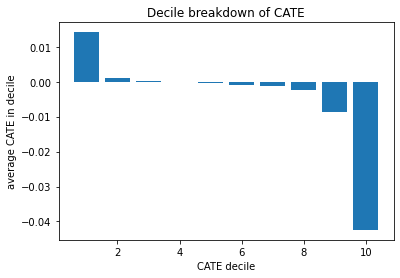

In [66]:
# obtain and plot CATE deciles in ascending order (target is attrition, so a lower/negative CATE means a decreasing or protective)
# treatment effect on predited attrition rate

# Calculate CATE as average CATE of models a and b
cate_a = dr_a.effect(x[features_list_decollinear])
cate_b = dr_b.effect(x[features_list_decollinear])
cate = (cate_a+cate_b)/2
df['avg_cf_DR_cate'] = cate

df_cate_deciles = df.sort_values(by=['avg_cf_DR_cate'], ascending=True)
df_cate_deciles['DR_cate_decile'] = pd.qcut(df['avg_cf_DR_cate'], 10, labels=range(10,0,-1))

df_cate_deciles_plt = df_cate_deciles.groupby('DR_cate_decile').agg(
    {
        'avg_cf_DR_cate' : 'mean'
    }
)
fig, ax = plt.subplots()

ax.bar(df_cate_deciles_plt.index, df_cate_deciles_plt['avg_cf_DR_cate'])

ax.set_ylabel('average CATE in decile')
ax.set_title('Decile breakdown of CATE')
ax.set_xlabel('CATE decile')

plt.show()

In [67]:
#looking into the bottom decile (a.k.a, the decile that has the lowest (negative) CATE, or the decile with the best 
#predicted treatment effect on attrition rate)

#mean and std; 95% CI
best_decile_mean = df_cate_deciles[df_cate_deciles['DR_cate_decile']==10]['avg_cf_DR_cate'].mean()
best_decile_std = df_cate_deciles[df_cate_deciles['DR_cate_decile']==10]['avg_cf_DR_cate'].std()

print('best decile CATE mean and 95% CI: ', best_decile_mean-best_decile_std*1.96, ' | ', best_decile_mean, ' | ', best_decile_mean+best_decile_std*1.96)

best decile CATE mean and 95% CI:  -0.12138713592366396  |  -0.04241439811194851  |  0.036558339699766934


#### 95% CI of ATE for best decile crosses 0, therefore we cannot conclude at a 95% confidence that there is any treatment effect even amongst the samples with the higest predicted uplift